In [95]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, datasets
import random
# from numba import jit, cuda

EPS = 1.0e-7

In [96]:
# Digits dataset for testing
# this dataset allows the algorithm to finish faster

from sklearn import datasets
from sklearn.datasets import load_digits

class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)
    
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [97]:
# folder to save results in
results_dir = "./results"

In [98]:
# # ALL DATA STUFF

# transform = transforms.Compose([
#     transforms.ToTensor(),
# ])

# # import MNIST dataset
# training_dataset = datasets.MNIST(
#     "data",
#     train=True,
#     download=True,
#     transform=transform
# )

# test_dataset = datasets.MNIST(
#     "data",
#     train=False,
#     download=True,
#     transform=transform
# )

# indices = [i for i in range(len(training_dataset))]
# train_split = int(len(training_dataset) * 0.8)
# train_dataset = Subset(training_dataset, indices[:train_split])
# val_dataset = Subset(training_dataset, indices[train_split:])


# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [99]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)
    

class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)

In [100]:
class CNN(nn.Module):
    def __init__(self, classnet):
        super(CNN, self).__init__()
        self.classnet = classnet
        self.nll = nn.NLLLoss(reduction='none')

    def classify(self, x):

        y_pred = torch.argmax(self.classnet(x), dim=1)

        return y_pred
    
    def forward(self, x, y, reduction="avg"):
        # x = x.type(torch.float32)   # Needed to turn the data into float32
                                    # in order to avoid a RuntimeError.
        loss = self.nll(self.classnet(x), y.long())

        if reduction == "avg":
            return loss.mean()
        elif reduction == "sum":
            return loss.sum()

In [101]:
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0

    for indx_batch, (test_batch, test_labels) in enumerate(test_loader):
        loss_test_batch = model_best.forward(test_batch, test_labels, reduction="sum") 
        loss_test += loss_test_batch.item()

        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_labels)
        loss_error += (1.0 - e).sum().item()

        N += test_batch.shape[0]

    loss_test /= N
    loss_error /= N

    # if epoch is None:
    #     print(f"FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    # else:
    #     if epoch % 2 == 0:
    #         print(f"EPOCH {epoch}: nll={loss_test}, ce={loss_error}")  

    return loss_test, loss_error


In [102]:
#TRAINING

def training(
        name, max_patience, num_epochs, model, optimizer, train_loader, val_loader
):

    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    for e in range(num_epochs):
        model.train()

        for indx_batch, (batch, targets) in enumerate(train_loader):

            loss = model.forward(batch, targets)

            optimizer.zero_grad()

            loss.backward(retain_graph=True)

            optimizer.step()

        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)
        error_val.append(error_e)

        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience += 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

In [103]:
# INITIALIZE THE POPULATION

# This dictionary holds all possible parameters for any CNN in the model space.
dict = {1: [8,16,32],                                   # Number of filters             
        2: [(3,1), (5,2)],                              # Kernel size and padding
        3: [nn.ReLU, nn.Sigmoid, nn.Tanh, nn.ELU],      # Activation fucntion
        4: [2, 1],                                      # Pooling
        5: [nn.AvgPool2d, nn.MaxPool2d],                # Pooling 
        6: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]    # Number of neurons
        }

def generate_individual(seed):
    """
    Generates a random individual for the evolutionary algorithm.
    """
    # Number of filters
    num_filters = dict[1][seed[0]]
    # Kernel size and padding
    kern_pad = dict[2][seed[1]]
    # Activation
    activation = dict[3][seed[2]]
    # Pooling
    pooling1 = dict[4][seed[3]]
    pooling2 = dict[5][seed[4]]
    # Linear layer 
    num_neurons = dict[6][seed[5]]

    return [num_filters, kern_pad, activation, pooling1, pooling2, num_neurons]


def generate_seed():
    """
    Generates a random seed for the evolutionary algorithm.
    """
    seed = [] # initialize the seed
    for i in range(6): # generate a random number for each parameter
        seed.append(np.random.randint(0, len(dict[i+1])))
    return seed

seeds = [] # Initialize the list of all seeds
while len(seeds) < 10: # Generate 10 seeds
    seed = generate_seed()
    if seed not in seeds: # Make sure the seed does not already exist
        seeds.append(seed) # Add the seed to the list of seeds

population = [] # Initialize the population
for seed in seeds: 
    population.append(generate_individual(seed)) # Generate an individual for each seed


In [104]:
result_dir = "./results"

# Training hyperparameters
lr = 1e-2 # learning rate
wd = 1e-5 # weight decay
num_epochs = 10  # number of epochs (max)
max_patience = 3 # patience for early stopping


class Network:
    def __init__(self, population):
        """
        Import the population and initialize all constants.
        """
        self.population = population
        self.H = 8                     # Height of the image
        self.W = 8                     # Width of the image   --> (28x28 - MNIST, 8x8 - Digits)
        self.D = 1                     # Input dimension     --> (1 - MNIST, Digits, 3 - SVHN)
        self.K = 10                    # Number of classes

    def run(self):        
        """
        Run the network on each individual in the population.
        """
        iter = -1 # Initialize the iteration number
        fitness = [] # Initialize the list of fitness values
        for i in range(len(self.population)):
            iter += 1  # Increment the iteration number
            name = "classifier_cnn" # Initialize the name of the model
            name += "_" 
            name += str(iter)  # Specify which cnn we are on
            # print(name)

            # Initialize the model
            num_kernels = self.population[i][0] # Number of kernels
            kernel_size = self.population[i][1][0] # Kernel size 
            padding = self.population[i][1][1] # Padding
            activation = self.population[i][2] # Activation function
            pooling1 = self.population[i][3] # Pooling
            pooling2 = self.population[i][4] # Pooling
            num_neurons = self.population[i][5] # M
            l_in = ((self.W * self.H * num_kernels) // pooling1)// pooling1 # input size to linear layer
            self.num_weights = (num_kernels * kernel_size * kernel_size * self.D) + (num_neurons * l_in) + (num_neurons * self.K) # number of weights
            self.weights_max = 628320 # maximum weight value


            size = [1,8,8] # 8's are ignored when not using Digits
            classnet = nn.Sequential(

                # Reshape the input to the correct shape for the convolutional layer
                Reshape(size),  

                # Convolutional layer
                nn.Conv2d(size[0], num_kernels, kernel_size=kernel_size, stride=1, padding=padding), 
                activation(), # Activation function

                # Pooling layer
                pooling2(pooling1, pooling1),

                # Flatten the output for the linear layer
                Flatten(),
                
                # Linear layer
                nn.Linear(l_in, num_neurons),
                activation(),
                
                # Output layer
                nn.Linear(num_neurons, self.K),  
                nn.LogSoftmax(dim=1),

            )

            model = CNN(classnet) # define the model

            optimizer = torch.optim.Adamax(
                [p for p in model.parameters() if p.requires_grad == True],
                lr=lr, 
                weight_decay=wd
            )
            
            # train the model
            nll_val, error_val = training(
                name=result_dir + name, 
                max_patience=max_patience, 
                num_epochs=num_epochs, 
                model=model, 
                optimizer=optimizer, 
                train_loader=train_loader, 
                val_loader=val_loader,
            )

            # run test
            test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
            f = open(result_dir + name + "_test_loss.txt", "w")
            f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
            f.close()


            # calcluate fitness value
            # fitness is calculated using the test error and the number of neurons in the linear layer
            fitness.append((test_error+(lr*((self.num_weights)/self.weights_max)), iter, self.population[i]))
            # equation: fitness = test_error + (lr * (Np/Nmax))
            # Np = number of neurons in the linear layer
            # Nmax = maximum number of neurons in the linear layer
            # lr = learning rate (0.01)

        # print the two lowest fitness values
        #fitness.sort(key=lambda x: x[0])
        #print ("Fitness: ", fitness[0:2])
        return fitness

            

In [105]:
class EvolutionaryAlgorithm:
    def __init__(self, network, population):
        self.network = network # initialize the network
        self.pop_size = len(population) # population size
        self.n_parents = self.pop_size # number of parents
        # bounds for mutation
        self.bounds_max = [len(dict[1]), 
                            len(dict[2]), 
                            len(dict[3]), 
                            len(dict[4]), 
                            len(dict[5]),
                            len(dict[6])] # upper bound for each parameter
        self.bounds_min = [0, 0, 0, 0, 0, 0] # lower bound for each parameter

    def parent_selection(self, x_old):
        # select n parents randomly from the population
        x_parents = random.sample(list(x_old), self.n_parents)

        return x_parents
    
    def recombination(self, x_parents):
        """
        Random Cross-over
        """
        x_children = [] # initialize the children

        # select random crossover point
        cross_over = np.random.randint(0, len(x_parents[0]))


        for i in range(self.n_parents//2):
            # select two random parents
            parents = random.sample(list(x_parents), 2)
            parent1 = parents[0] # define parent 1
            parent2 = parents[1] # define parent 2

            # combine parent 1 and parent 2 at crossover point
            child1 = np.concatenate((parent1[:cross_over], parent2[cross_over:]), axis=None)
            child2 = np.concatenate((parent2[:cross_over], parent1[cross_over:]), axis=None)

            #add child1 and child2 to children
            x_children.append(child1)
            x_children.append(child2)
            
        # add children to population
        x_children = np.concatenate([x_children, x_parents])

        return x_children
    
    def mutation(self, x_children):
        """
        Random mutation
        """
        for i in range(int(len(x_children)//2)): # mutate half of the population
            # select random individual
            child = np.random.randint(0, len(x_children))

            # select random mutation point
            mutation_point = np.random.randint(0, len(x_children[i]))

            # select random mutation value
            mutation_value = np.random.randint(self.bounds_min[mutation_point], self.bounds_max[mutation_point])

            # mutate
            x_children[child][mutation_point] = dict[mutation_point+1][mutation_value]
            # print("Mutation: " + str(child) + " " + str(mutation_point) + " " + str(mutation_value))
        
        return x_children

    def survivor_selection(self, f_children):
        """
        Survivor selection
        Sort the population by fitness 
        The 10 best will be selected as parents
        """
        # sort the population by fitness
        f_children.sort()

        # select the best individuals
        f = f_children[:self.pop_size]

        # print the best fitness value of that generation
        print("Best Fitness (gen): " + str(f[0][0]))

        # select the configuration of the best individuals
        for i in range(len(f)):
            f[i] = f[i][2]

        return f
    
    def evaluate(self, x_children):
        """
        Run the network which each configuration
        """
        net = self.network(x_children) 
        result = net.run() 
        return result
    
    def step(self, x_old):

        x_parents = self.parent_selection(x_old) # select parents
        x_children = self.recombination(x_parents) # recombination
        x_children = self.mutation(x_children) # mutation
        f_children = self.evaluate(x_children) # evaluate the children
        x_new = self.survivor_selection(f_children) # survivor selection

        return x_new , f_children

Generation:  1
Best Fitness (gen): 0.0694846019554863
BEST FITNESS: 0.0694846019554863
Generation:  2
Best Fitness (gen): 0.06277319255951314
BEST FITNESS: 0.06277319255951314
Generation:  3
Best Fitness (gen): 0.06277319255951314
BEST FITNESS: 0.06277319255951314
Generation:  4
Best Fitness (gen): 0.06277319255951314
BEST FITNESS: 0.06277319255951314
Generation:  5
Best Fitness (gen): 0.05606178316353997
BEST FITNESS: 0.05606178316353997
Generation:  6
Best Fitness (gen): 0.05614237903825349
BEST FITNESS: 0.05606178316353997
Generation:  7
Best Fitness (gen): 0.06099696773157097
BEST FITNESS: 0.05606178316353997
Generation:  8
Best Fitness (gen): 0.05452664567962633
BEST FITNESS: 0.05452664567962633
Generation:  9
Best Fitness (gen): 0.056522694800922195
BEST FITNESS: 0.05452664567962633
Generation:  10
Best Fitness (gen): 0.056522694800922195
BEST FITNESS: 0.05452664567962633
Generation:  11
Best Fitness (gen): 0.051716107126193976
BEST FITNESS: 0.051716107126193976
Generation:  12
B

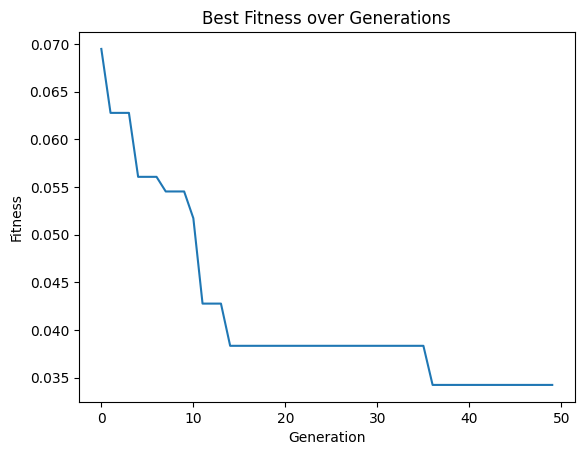

In [106]:
num_generations = 50

# initialize the evolutionary algorithm
ea = EvolutionaryAlgorithm(Network, population) 

# run the evolutionary algorithm
best = None # initialize the best fitness value
best_list = [] # initialize the list of overall best fitness values 

for generation in range(num_generations):
    print("Generation: ", generation+1)
    population, f_and_c = ea.step(population)

    # print(f_and_c[0][0])

    if best == None:
        # if best is None, initialise first fitness value
        best = f_and_c[0]
        best_list.append(best[0])
    elif best[0] > f_and_c[0][0]: 
        # if new fitness value is better than old one, replace it
        best = f_and_c[0]
        best_list.append(best[0])
    else:
        # if new fitness value is worse than old one, re-add old one
        best_list.append(best[0])
    
    # print the best fitness value of that generation
    print("BEST FITNESS: " + str(best[0])) 

    # save the overall best fitness value and config of that generation
    f = open(result_dir + "best.txt", "w")
    f.write("Fitness: " + str(best[0]) + "\nConfiguration: " + str(best[2]))
    f.close()

    
print("FINISHED!")

print("Best Configuration: " + str(best[2]))

# plot the best fitness over num_generations
plt.plot(best_list)
plt.xlabel("Generation") 
plt.ylabel("Fitness")
plt.title("Best Fitness over Generations")
plt.savefig(result_dir + "best_fitness.png")
plt.show()


